## Web scraping and analysis

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import re
from wordcloud import WordCloud
from textblob import TextBlob
import spacy

### Scraping Reviews from [https://www.airlinequality.com/airline-reviews/british-airways]
Using Python and BeautifulSoup to collect all the links to the reviews and then to collect the text data on each of the individual review links.

In [3]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 10
page_size = 100

reviews = []

# for i in range(1, pages + 1):
for i in range(1, pages + 1):

    print(f"Scraping page {i}")

    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())
    
    print(f"   ---> {len(reviews)} total reviews")

Scraping page 1
   ---> 100 total reviews
Scraping page 2
   ---> 200 total reviews
Scraping page 3
   ---> 300 total reviews
Scraping page 4
   ---> 400 total reviews
Scraping page 5
   ---> 500 total reviews
Scraping page 6
   ---> 600 total reviews
Scraping page 7
   ---> 700 total reviews
Scraping page 8
   ---> 800 total reviews
Scraping page 9
   ---> 900 total reviews
Scraping page 10
   ---> 1000 total reviews


In [20]:
df = pd.DataFrame()
df["reviews"] = reviews
df.head()

,reviews
0,"✅ Trip Verified | Check in was so slow, no se..."
1,✅ Trip Verified | My review relates to the ap...
2,✅ Trip Verified | This was my first time flyin...
3,✅ Trip Verified | Lots of cancellations and d...
4,✅ Trip Verified | BA 242 on the 6/2/23. Boardi...


In [21]:
#df.to_csv("/Users/yashitavajpayee/Desktop/Project/Forage_American_AirlinesBA_reviews.csv")

In [22]:
# split the 'reviews' column into two columns based on the '|' character
df[['Trip Verification', 'Comments']] = df['reviews'].str.split('|', expand=True)

# print the resulting dataframe
df = df.drop('reviews', axis=1)
df.head(3)

,Trip Verification,Comments
0,✅ Trip Verified,"Check in was so slow, no self check in and b..."
1,✅ Trip Verified,My review relates to the appalling experienc...
2,✅ Trip Verified,This was my first time flying with BA & I was...


In [23]:
df['Comments'] = df['Comments'].astype(str)

In [24]:
## Data cleaning and processing

df['Trip Verification'] = df['Trip Verification'].str.replace('✅ Trip Verified', 'Verified')
df['Trip Verification'] = df['Trip Verification'].str.replace('❎ Not Verified', 'Not Verified')
    
# replace all occurrences of '✅ Trip Verified' with 'Verified'

# print the updated dataframe
df.head()


,Trip Verification,Comments
0,Verified,"Check in was so slow, no self check in and b..."
1,Verified,My review relates to the appalling experienc...
2,Verified,This was my first time flying with BA & I was...
3,Verified,Lots of cancellations and delays and no one ...
4,Verified,BA 242 on the 6/2/23. Boarding was delayed du...


### EDA and Visualizations

In [25]:
df.describe()

,Trip Verification,Comments
count,1000,1000
unique,2,1000
top,Verified,"Check in was so slow, no self check in and b..."
freq,829,1


#### Pie-chart to know how many trips were verified and not verified
We can figure the sentiments of people based off the status of their trip

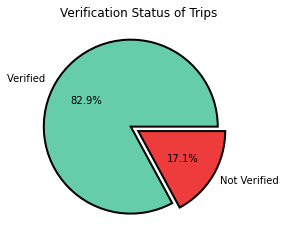

In [9]:
counts = df['Trip Verification'].value_counts()
percentages = counts / len(df) * 100
plt.pie(percentages, labels=percentages.index, autopct='%1.1f%%',colors=['#66CDAA', '#EE3B3B'],explode=[0.1, 0],\
       wedgeprops={'edgecolor': 'black', 'linewidth': 2})

# add a title
plt.title('Verification Status of Trips')

# show the chart
plt.show()

#### Word Cloud to know most frequent words used for Verfied and Not verified trips

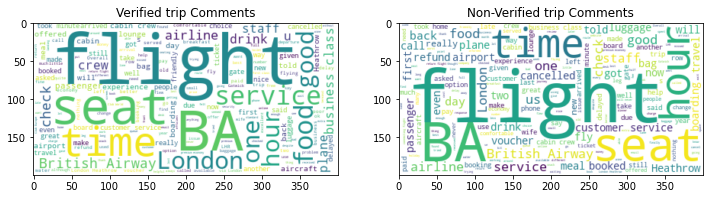

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# generate word cloud for verified comments
verified_comments = ' '.join(df[df['Trip Verification'].str.contains('Verified')]['Comments'].tolist())
wordcloud_verified = WordCloud(background_color='white').generate(verified_comments)
ax[0].imshow(wordcloud_verified, interpolation='bilinear')
ax[0].set_title('Verified trip Comments')

# generate word cloud for non-verified comments
non_verified_comments = ' '.join(df[df['Trip Verification'].str.contains('Not Verified')]['Comments'].tolist())
wordcloud_non_verified = WordCloud(background_color='white').generate(non_verified_comments)
ax[1].imshow(wordcloud_non_verified, interpolation='bilinear')
ax[1].set_title('Non-Verified trip Comments')
plt.show()

### Sentiment Analysis
Using *TextBlob* Library we get Sentiment Polarity and Sentiment Subjectivity.

Polarity is the output that lies between [-1,1], where -1 refers to negative sentiment and +1 refers to positive sentiment. Subjectivity is the output that lies within [0,1] and refers to personal opinions and judgments.

In [11]:
def get_sentiment_polarity(Comments):
    blob = TextBlob(Comments)
    return blob.sentiment.polarity

def get_sentiment_subjectivity(Comments):
    
    return TextBlob(Comments).sentiment.subjectivity

# apply the function to the 'review' column and store the results in a new column called 'sentiment'
df['Sentiment Polarity'] = df['Comments'].apply(get_sentiment_polarity)
df['Sentiment Subjectivity'] = df['Comments'].apply(get_sentiment_subjectivity)

df.head()

,Trip Verification,Comments,Sentiment Polarity,Sentiment Subjectivity
0,Verified,"Check in was so slow, no self check in and b...",0.289365,0.463651
1,Verified,My review relates to the appalling experienc...,-0.039437,0.434336
2,Verified,This was my first time flying with BA & I was...,0.213532,0.569444
3,Verified,Lots of cancellations and delays and no one ...,0.125000,0.250000
4,Verified,BA 242 on the 6/2/23. Boarding was delayed du...,0.493750,0.684375


#### Box plot to understand statistic values of Sentiment Polarity and Subjectivity 

In [12]:
### Classifying Comments according to sentiments polarity as positive or negative ###

df['Sentiment'] = df['Sentiment Polarity'].apply(lambda x: 'negative' if x < 0 else 'positive')
df.head()

,Trip Verification,Comments,Sentiment Polarity,Sentiment Subjectivity,Sentiment
0,Verified,"Check in was so slow, no self check in and b...",0.289365,0.463651,positive
1,Verified,My review relates to the appalling experienc...,-0.039437,0.434336,negative
2,Verified,This was my first time flying with BA & I was...,0.213532,0.569444,positive
3,Verified,Lots of cancellations and delays and no one ...,0.125000,0.250000,positive
4,Verified,BA 242 on the 6/2/23. Boarding was delayed du...,0.493750,0.684375,positive


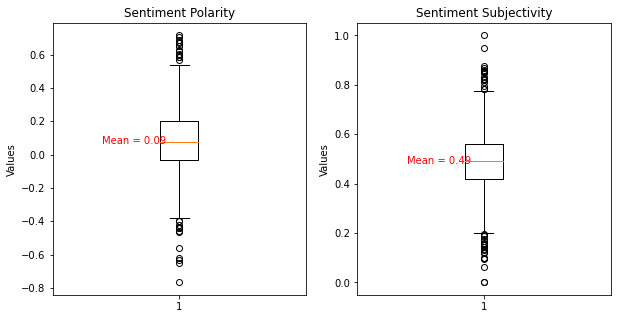

In [13]:
# create figure and axis objects with subplots()
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# plot the data
axs[0].boxplot(df['Sentiment Polarity'])
axs[1].boxplot(df['Sentiment Subjectivity'])

# set labels and titles
axs[0].set_title('Sentiment Polarity')
axs[0].set_ylabel('Values')
axs[0].text(0.95, df['Sentiment Polarity'].mean(), f"Mean = {df['Sentiment Polarity'].mean():.2f}", ha='right', va='center', color='r')
axs[1].set_title('Sentiment Subjectivity')
axs[1].set_ylabel('Values')
axs[1].text(0.95, df['Sentiment Subjectivity'].mean(), f"Mean = {df['Sentiment Subjectivity'].mean():.2f}", ha='right', va='center', color='r')

plt.show()


#### Re-classifying
This time I will denote comments with sentiment polarity less than mean value as negative and above as positive.

Also I will similarly classify subjectivity of comments as objective or subjective based on the mean value

In [14]:
df['Sentiment'] = df['Sentiment Polarity'].apply(lambda x: 'negative' if x < 0.09 else 'positive')
df['Sentiment type'] = df['Sentiment Subjectivity'].apply(lambda x: 'Objective' if x < 0.49 else 'Subjective')
df.head()

,Trip Verification,Comments,Sentiment Polarity,Sentiment Subjectivity,Sentiment,Sentiment type
0,Verified,"Check in was so slow, no self check in and b...",0.289365,0.463651,positive,Objective
1,Verified,My review relates to the appalling experienc...,-0.039437,0.434336,negative,Objective
2,Verified,This was my first time flying with BA & I was...,0.213532,0.569444,positive,Subjective
3,Verified,Lots of cancellations and delays and no one ...,0.125000,0.250000,positive,Objective
4,Verified,BA 242 on the 6/2/23. Boarding was delayed du...,0.493750,0.684375,positive,Subjective


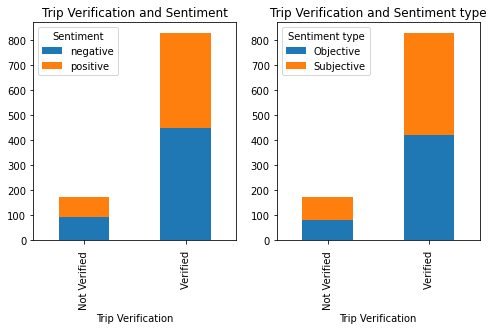

In [18]:
gr1 = df.groupby(['Trip Verification', 'Sentiment']).size().unstack(fill_value=0)
gr2 = df.groupby(['Trip Verification', 'Sentiment type']).size().unstack(fill_value=0)

# plot stacked bar charts in subplots
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
gr1.plot(kind='bar', stacked=True, ax=ax[0])
ax[0].set_title('Trip Verification and Sentiment')
ax[0].legend(title='Sentiment')


# plot stacked bar charts with percentages
gr2.plot(kind='bar', stacked=True, ax=ax[1])
ax[1].set_title('Trip Verification and Sentiment type')
ax[1].legend(title='Sentiment type')

plt.show()